Cargar el dataframe resultado del preprocesamiento

In [34]:
from dataloader import ETL
import pandas as pd

file_path = 'dataframe_merge.xlsx'
etl_fusion = ETL(file_path)
df_fusion = pd.read_excel(file_path)

Tipos de variables

In [35]:
df_fusion.dtypes.value_counts()

int64      11
object      9
float64     2
Name: count, dtype: int64

El dataframe fusionado posee 13 variables de tipo numérico, 11 con valores enteros y 2 con valores flotantes. Además posee 9 variables con valores categóricos

Métricas descriptivas de las características

In [36]:
df_fusion.describe()

,film_id,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,num_voted_users,inventory_id,store_id,rental_id,customer_id,staff_id
count,16088.000000,16088.0,16088.0,16088.000000,16088.000000,16088.000000,16088.000000,16088.000000,16088.000000,16088.000000,16088.000000,16088.000000,16088.000000
mean,500.814582,2006.0,1.0,4.932185,2.951213,114.810977,20.265813,39241.229488,2290.506278,1.999254,8029.785306,297.216497,1.498633
std,288.077662,0.0,0.0,1.400854,1.650959,40.062412,6.091701,22430.929911,1320.203439,0.027302,4631.653412,172.432975,0.500014
min,1.000000,2006.0,1.0,3.000000,0.990000,46.000000,9.990000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,256.000000,2006.0,1.0,4.000000,0.990000,80.000000,14.990000,19050.000000,1161.000000,2.000000,4022.750000,147.750000,1.000000
50%,494.000000,2006.0,1.0,5.000000,2.990000,113.000000,20.990000,39250.000000,2285.000000,2.000000,8025.500000,296.000000,1.000000
75%,752.000000,2006.0,1.0,6.000000,4.990000,148.000000,25.990000,58650.000000,3430.000000,2.000000,12041.250000,446.000000,2.000000
max,1000.000000,2006.0,1.0,7.000000,4.990000,185.000000,29.990000,76900.000000,4581.000000,2.000000,16049.000000,599.000000,2.000000


Matriz de correlación

In [42]:
# Descartar las variables ordinales
df_no_ord = df_fusion.drop(columns=['film_id', ' release_year', ' language_id', 'inventory_id', ' store_id',  'rental_id',' customer_id', ' staff_id']).describe()

In [38]:
df_no_ord.corr()

,rental_duration,rental_rate,length,replacement_cost,num_voted_users
rental_duration,1.000000,1.000000,0.999965,0.999999,-0.289722
rental_rate,1.000000,1.000000,0.999965,0.999999,-0.289714
length,0.999965,0.999965,1.000000,0.999974,-0.282101
replacement_cost,0.999999,0.999999,0.999974,1.000000,-0.288768
num_voted_users,-0.289722,-0.289714,-0.282101,-0.288768,1.000000


Text(0.5, 1.0, 'Mapa de Calor')

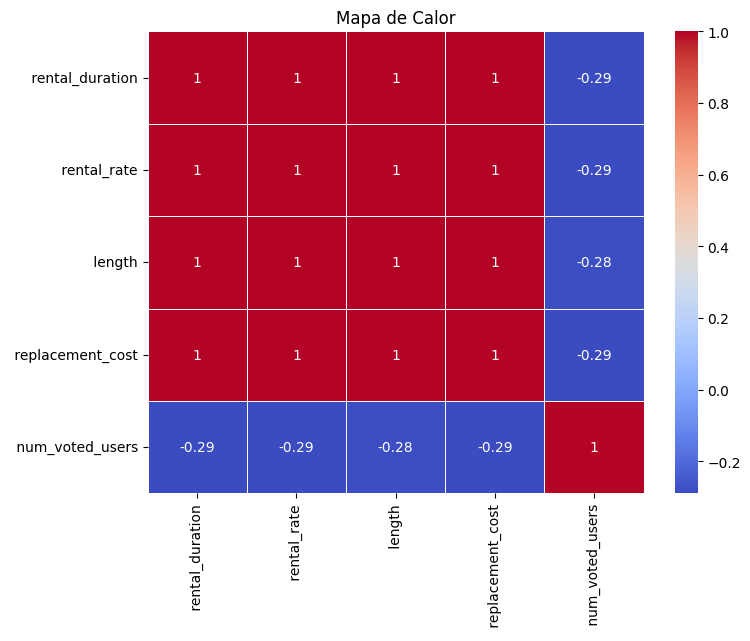

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Tamaño de la figura
sns.heatmap(df_no_ord.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Mapa de Calor')


#### De acuerdo con los resultados de correlación, las variables tienen relación lineal perfecta, lo cual es sospechoso para un grupo de 4 variables. A partir de este resultado no se puede concluir por ejemplo, del grado de indicidencia de la duración en la tasa de renta. 

# Preguntas

## 1. ¿Cuántas y cuál es el costo de reposición de las películas no devueltas?

In [ ]:
columns =  [' return_date']
null_values = etl_fusion.null_count(df_fusion, columns)

for i in range(len(columns)):
    print('Valores faltantes columna %s son %i' %( columns[i], len(null_values[i])))

2024-11-15 23:52:56,852 -- dataloader -- DEBUG -- Valores NULL detectados
2024-11-15 23:52:56,853 -- dataloader -- INFO -- El método null_count tardó 0.0100 segundos en ejecutarse.


Valores faltantes columna  return_date son 183


En este caso la cantidad de valores 'NULL' de la columna ' return_date' se pueden interpretar como elementos que no fueron regresados, es decir, películas que se perdieron. Teniendo en cuenta que cada película tiene asociado un costo de reposición, entonces es posible calcular el costo total de reposición de películas perdidas.

In [ ]:
costo_total = etl_fusion.sum_index(df_fusion, ' replacement_cost', null_values[0])
print('El costo de la reposición de las películas perdidas es de: ', round(costo_total,2))

2024-11-15 23:52:56,863 -- dataloader -- DEBUG -- Cálculo realizado
2024-11-15 23:52:56,864 -- dataloader -- INFO -- El método sum_index tardó 0.0020 segundos en ejecutarse.


El costo de la reposición de las películas perdidas es de:  3552.17


#### Hay registros de 183 películas no devueltas, a las cuales se asocia un costo de reposición de 3552.17 unidades monetarias. Por otra parte, con los datos recolectados es posible detectar quienes son los usuarios que no devolvieron las películas a través de su id y enviarles un correo electrónico de recordatorio. 

## 2. ¿Cuál es el ranking de películas más rentadas?

In [ ]:
most_movies = df_fusion[' title'].value_counts().reset_index().head(5)

most_movies

,title,count
0,FLAMINGOS CONNECTICUT,92
1,BUCKET BROTHERHOOD,34
2,ROCKETEER MOTHER,33
3,FORWARD TEMPLE,32
4,GRIT CLOCKWORK,32


In [ ]:
mrm = most_movies[' title'].tolist()

df_filtrado = df_fusion[df_fusion[' title'].isin(mrm)]

df_filtrado[[' rating', ' title']].drop_duplicates()

,rating,title
1613,PG,BUCKET BROTHERHOOD
5083,PG-13,FLAMINGOS CONNECTICUT
5340,NC-17,FORWARD TEMPLE
6183,PG,GRIT CLOCKWORK
11811,PG-13,ROCKETEER MOTHER


#### De acuerdo con la base de datos en la tabla anterior se encuentran las 5 películas con mayor cantidad de registros de renta, esta información es útil para ampliar la cantidad de películas con este título o complementar el catálogo con precuelas y secuelas de estas películas, buscar títulos del mismo director o categoría

## 3. ¿Cuáles son los clientes que más películas han rentado?

In [ ]:
# Cargar la información de los consumidores
archivo_excel = 'Films_2 (3).xlsx'  
df = pd.read_excel(archivo_excel, sheet_name='customer')

In [ ]:
df_fusion[' customer_id'].value_counts().reset_index().head(5)

,customer_id,count
0,148,46
1,526,45
2,236,42
3,144,42
4,75,41


In [ ]:
idc = df_fusion[' customer_id'].value_counts().reset_index().head(5)[' customer_id'].tolist()
df_filtrado = df[df['customer_id'].isin(idc)]

df_filtrado[[' first_name', ' last_name']]

,first_name,last_name
74,TAMMY,SANDERS
143,CLARA,SHAW
147,ELEANOR,HUNT
235,MARCIA,DEAN
525,KARL,SEAL


#### En la tabla anterior se muestran los nombres y los índices de las personas que mayor número de rentas tienen registradas en la base de datos, con esta información pueden crearse pases o promociones especiales para los clientes de acuerdo con rangos de rentas en periodos de tiempo definidos

array([<Axes: ylabel='count'>], dtype=object)

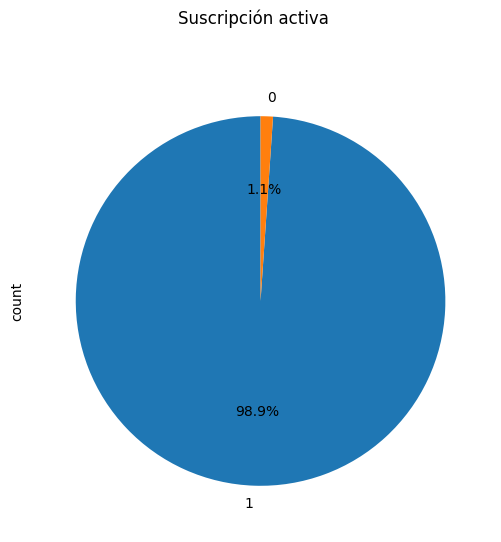

In [ ]:
df[' active'].value_counts().plot(kind='pie', 
                                subplots=True,
                                autopct='%1.1f%%', 
                                startangle=90, 
                                figsize=(6, 6), 
                                title='Suscripción activa')

#### Asumiendo 1 como activo y 0 como activo se puede decir que el 98.9% de los clientes de la base de datos están activos

## 4. ¿Cuál es el ranking de segmentos? 

In [ ]:
df_fusion[' rating'].value_counts().reset_index()

,rating,count
0,PG-13,3629
1,NC-17,3293
2,PG,3212
3,R,3181
4,G,2773


array([<Axes: ylabel='count'>], dtype=object)

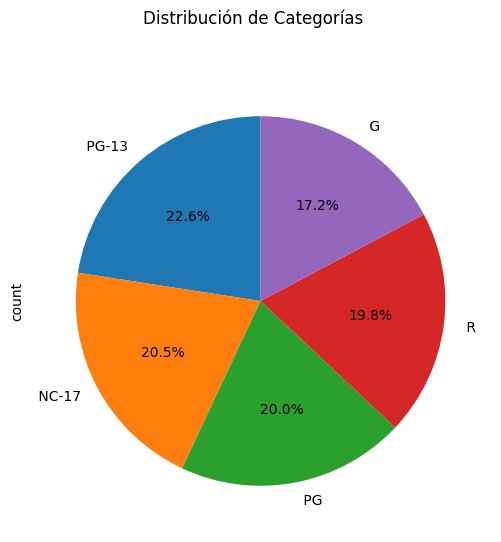

In [ ]:
df_fusion[' rating'].value_counts().plot(kind='pie', 
                                        subplots=True,
                                        autopct='%1.1f%%', 
                                        startangle=90, 
                                        figsize=(6, 6), 
                                        title='Distribución de Categorías')

#### La gráfica previamente presentada describe el interés que tiene la población en cada categoría, esto podría guiar la toma de decisiones respecto a la adición de nuevas películas

## 5. ¿Cómo cuantificar la perdida o riesgo con una película que no es devuelta o que no se renta regularmente? 

Para dar respuesta a esta pregunta se define el índice_r:

$índice\_r = \frac{replacement\_cost}{rental\_rate}$

Este índice relaciona la tasa de renta, la cual se asume como un indicador de las veces que se renta una película en un periodo de tiempo con el costo de reemplazo, el cual se asume como la inversión que implica reponer una pelicula no devuelta. 

Este indice es inversamente proporcial a la tasa de renta, es decir, entre más veces sea rentada en ese periodo de tiempo, menor es la reserva de para reemplazarlo, es decir, que entre menor sea este índice menor es el riesgo que se corre al rentar esa película. Valores altos de este índice implica que hay un mayor capital en riesgo al no ser devuelta la película.

In [ ]:
file = 'df_film_processed.xlsx'
df_film_clean = pd.read_excel(file)

In [ ]:
df_nuevo = pd.DataFrame({
    'Título': df_film_clean[' title'], 
    'índice_r': df_film_clean[' replacement_cost'] / df_film_clean[' rental_rate'] 
})

df_nuevo.sort_values(by='índice_r', ascending=True).head(5)

,Título,índice_r
259,DUDE BLINDNESS,2.002004
271,EDGE KISSING,2.002004
890,THIN SAGEBRUSH,2.002004
202,DAISY MENAGERIE,2.002004
306,FELLOWSHIP AUTUMN,2.002004


#### Son de especial interés las películas con menor índice r, por lo cual son de especial interés las películas presentadas en la tabla anterior, como se mencionó previamente son aquellas cuya renta implica un menor riesgo de pérdida en caso de no ser devuelta, al ser rentada mayor cantidad de veces, ha dejado mayores ganancias para el negocio a lo largo del tiempo. Aquellas películas con un índice r alto, deberían tener una política especial de renta debido al riesgo de la inversión en la reposición o analizar su posibilidad de retiro del catálogo.

# Concluciones

- De acuerdo con la distibución de categorias, no hay desvalance fuerte, sin embargo la categoria PG-13 posee al menos 2 puntos porcentuales de mayor demanda respecto a las demás categorias
- Las 5 películas más rentadas de la base de datos, pertenecen a las 3 categorías más rentadas de la base de datos
- La base de datos aportada posee únicamente información de las películas lanzadas en el año 2006, lo cual podría significar un análisis muy específico, adicionalmente no se aportan variables que den información de costo de operación o de rentabilidad de la operación lo cual imposibilita un análisis económico del negocio. 